In [70]:
import math, subprocess
import pandas as pd
import numpy as np
import random, math
import os
import shutil
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import sys
from sklearn.decomposition import PCA
from IPython.display import display, clear_output
np.set_printoptions(threshold=sys.maxsize)

# Análisis PCA


## Con los datos de Facebook, computar la matriz de similaridad con producto interno de la matriz de atributos, con un umbral u y construir un grafo conectando los nodos que superan ese umbral.

In [71]:
def matriz_similaridad(matrix):
    XT = matrix.transpose()
    X = matrix
    return np.matmul(X, XT)

In [72]:
def estimar_facebook(m_similaridad, umbral):
    if umbral < 0: umbral = 0
    fb_A = np.zeros(m_similaridad.shape, dtype=int)
    for i in range(0, len(m_similaridad)):
        for j in range(0, len(m_similaridad)):
            if m_similaridad[i][j] > umbral:
                fb_A[i][j] = 1
    return fb_A

In [ ]:
G = nx.read_edgelist('facebook/1684.edges')
m_adyacencia = np.array(nx.adjacency_matrix(G).todense())
F = np.loadtxt('facebook/1684.feat')
df = pd.DataFrame(F).set_index(0)
m_attrs = df.loc[list(map(int,G.nodes()))].values

In [74]:
m_similaridad = matriz_similaridad(m_attrs)

In [ ]:
u = 5
print("la cantidad de atributos: " + str(m_attrs.shape[1]))
print(F"matriz de amistades si dos personas comparten mas de {u} atributos")
amistades = estimar_facebook(m_similaridad, u)



## Queremos comparar la red de amistades original y la construida a partir de los datos. 

In [76]:
def buscar_correlaciones(mat_similaridad, mat_adyacencia, min_attrs, max_attrs):
    m_ady_flatten = mat_adyacencia.flatten()
    correlaciones = []
    umbrales = []
    for num in range(min_attrs, max_attrs+1):
        estimado = estimar_facebook(mat_similaridad, num)
        cor = correlacion(estimado.flatten(), m_ady_flatten)
        correlaciones.append(cor)
        umbrales.append(num)
    return [umbrales, correlaciones]

In [77]:
def correlacion(x, y):
    n = x.shape
    sum_num = 0
    sum_dem_a = 0
    sum_dem_b = 0
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    
    for i in range(0, len(x)):
        op_x_mu = (x[i] - mu_x)
        op_y_mu = (y[i] - mu_y)

        sum_num += (op_x_mu)*(op_y_mu)
        sum_dem_a += (op_x_mu)**2
        sum_dem_b += (op_y_mu)**2
        
    sum_dem = (math.sqrt(sum_dem_a))*(math.sqrt(sum_dem_b))
    cor = 0
    if sum_dem != 0:
        cor = sum_num / sum_dem
    return cor

In [78]:
(umbrales, correlaciones) = buscar_correlaciones(m_similaridad, m_adyacencia, -2, 10)


## Buscar el umbral optimo que genera la red de atributos mas similar al grafo de amistades.

In [79]:
correlaciones_original = correlaciones

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


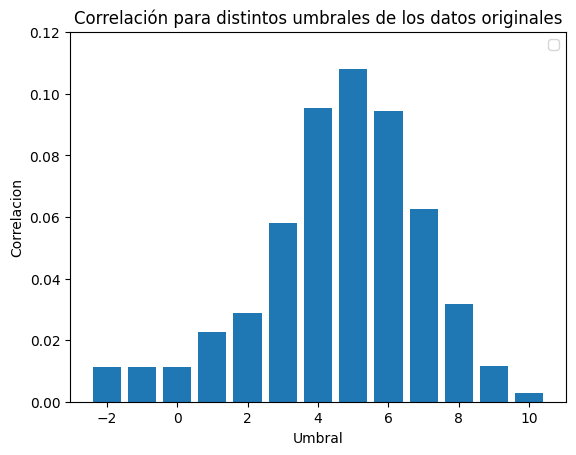

In [100]:
fig, ax = plt.subplots()

#ax.plot(umbrales, correlaciones_original)
plt.ylim(0, 0.12)
plt.legend()
plt.title("Correlación para distintos umbrales de los datos originales")
plt.xlabel("Umbral")
plt.ylabel("Correlacion")
plt.bar(umbrales, correlaciones_original)
plt.savefig(F"graficos/correlaciones_original.svg")


## Filtrar la matriz de atributos utilizando PCA: Computar la matriz de covarianza, luego los autovectores. Seleccionar k componentes principales y proyectar los datos al nuevo espacio. Repetir el punto anterior para varios valores de k y varios valores de u. 

In [81]:
def matriz_covarianza(matriz):
    X = matriz.copy()
    m = len(X)
    n = len(X[0])
    mu = np.zeros(n)
    
    for i in range(0, n):
        suma = 0.0
        for j in range(0, m):
            suma = suma + X[j][i]
        suma = (suma / m)
        mu[i] = suma

    Xc = []
    for i in range(0, len(X)):
        Xc.append(X[i] - mu)
    Xc = np.array(Xc)
    XcT = Xc.T
    C = (XcT@Xc)/(n-1)
    return C

In [82]:
m_covarianza = matriz_covarianza(m_attrs)

In [83]:
(eigenvalues, eigenvectors) = np.linalg.eig(m_covarianza)

In [84]:
componentes = [2, 3, 6, 8, 30, 50, 100, 319]
matrices_PCA = []
for k in range(0, len(componentes)):
    V_K = eigenvectors[ : ,:componentes[k]]
    VT_K = V_K.T
    m_comprimida = m_attrs@V_K
    matrices_PCA.append(m_comprimida)

In [85]:
data = []
for k in range(0, len(matrices_PCA)):
    m_sim_aux = matriz_similaridad(matrices_PCA[k])
    umbrales, correlaciones = buscar_correlaciones(m_sim_aux, m_adyacencia, -2, 10)
    data.append([componentes[k], umbrales, correlaciones])

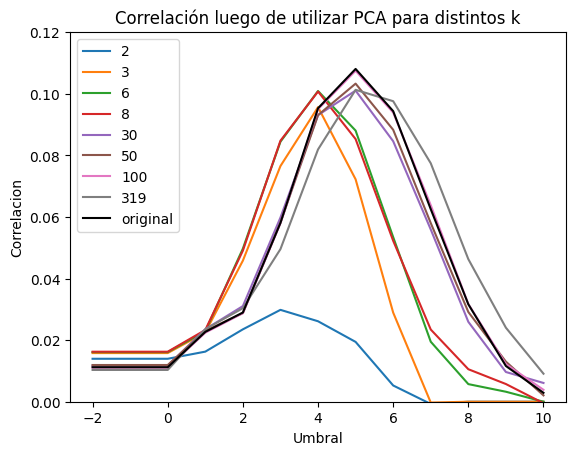

In [101]:
fig, ax = plt.subplots()
for i in range(0, len(componentes)):
    ax.plot(data[i][1], data[i][2], label=F"{data[i][0]}")
ax.plot(data[i][1], correlaciones_original, color="black", label="original")
plt.ylim(0, 0.12)
plt.legend()
plt.title("Correlación luego de utilizar PCA para distintos k")
plt.xlabel("Umbral")
plt.ylabel("Correlacion")
plt.savefig(F"graficos/correlaciones_PCA.svg")

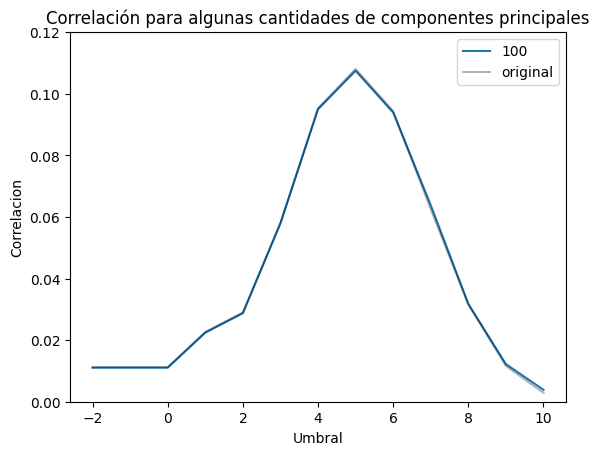

In [102]:
fig, ax = plt.subplots()
ax.plot(data[0][1], data[6][2], label=F"{data[6][0]}")
#ax.plot(data[0][1], data[7][2], label=F"{data[7][0]}")
ax.plot(data[i][1], correlaciones_original, color="black", label="original", alpha=0.3)
plt.ylim(0, 0.12)
plt.legend()
plt.title("Correlación para algunas cantidades de componentes principales")
plt.xlabel("Umbral")
plt.ylabel("Correlacion")
plt.savefig(F"graficos/correlaciones_PCA_k100.svg")

In [88]:
matrices_PCA_all = []
for k in range(1, 320):
    V_K = eigenvectors[ : ,:k]
    VT_K = V_K.T
    m_comprimida = m_attrs@V_K
    matrices_PCA_all.append(m_comprimida)

In [89]:
data_all = []
for k in range(0, len(matrices_PCA_all)):
    m_sim_aux = matriz_similaridad(matrices_PCA_all[k])
    umbrales, correlaciones = buscar_correlaciones(m_sim_aux, m_adyacencia, 5, 5)
    data_all.append([k+1, umbrales, correlaciones])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


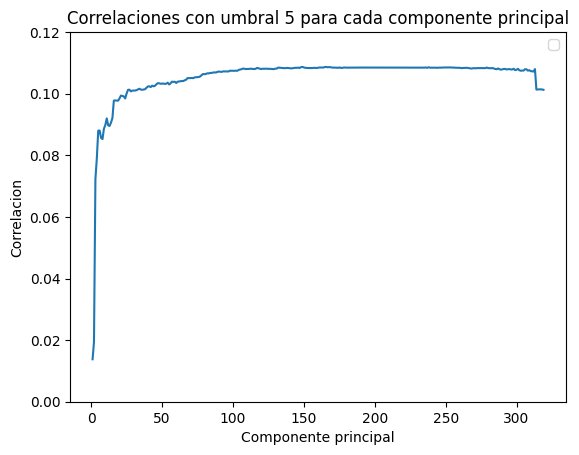

In [103]:
comp = []
for i in range(0, len(data_all)):
    comp.append(data_all[i][2][0])

indices = []
for i in range(1, 320):
    indices.append(i)

fig, ax = plt.subplots()
ax.plot(indices, comp)
#ax.plot(data[i][1], correlaciones_original, label="original")
plt.ylim(0, 0.12)
plt.legend()
plt.title("Correlaciones con umbral 5 para cada componente principal")
plt.xlabel("Componente principal")
plt.ylabel("Correlacion")
plt.savefig(F"graficos/correlaciones_umbral5.svg")

## Conclusion: Llega un punto en el que agregar mas componentes principales no varia significativamente la correlación.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


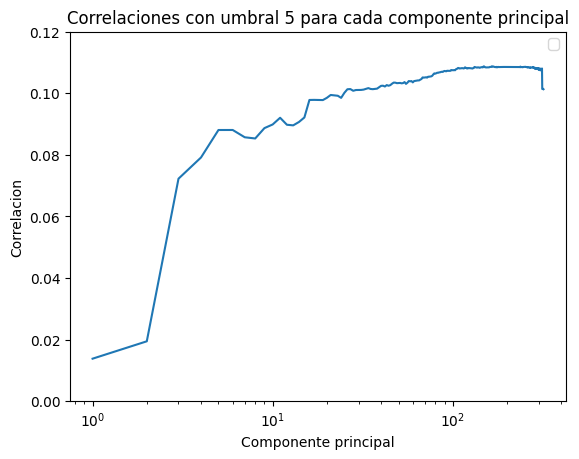

In [104]:
comp = []
for i in range(0, len(data_all)):
    comp.append(data_all[i][2][0])

indices = []
for i in range(1, 320):
    indices.append(i)

fig, ax = plt.subplots()
ax.plot(indices, comp)
#ax.plot(data[i][1], correlaciones_original, label="original")
plt.ylim(0, 0.12)
plt.legend()
plt.title("Correlaciones con umbral 5 para cada componente principal")
plt.xlabel("Componente principal")
plt.ylabel("Correlacion")
ax.set_xscale('log')
plt.savefig(F"graficos/correlaciones_umbral5log.svg")

## Busco la cantidad de componentes principales que mas se asemejan a los datos originales

In [92]:
cor = correlaciones_original[7]
mejor = 0
for i in range(1, 319):
    if(abs(data_all[i][2][0] - cor) < abs(data_all[mejor][2][0] - cor)):
        mejor = i
print(mejor)

109


In [93]:
V_K = eigenvectors[ : ,:110]
VT_K = V_K.T
mejor_matriz = m_attrs@V_K

m_sim_aux = matriz_similaridad(mejor_matriz)
umbrales, mejor_correlacion = buscar_correlaciones(m_sim_aux, m_adyacencia, -2, 10)

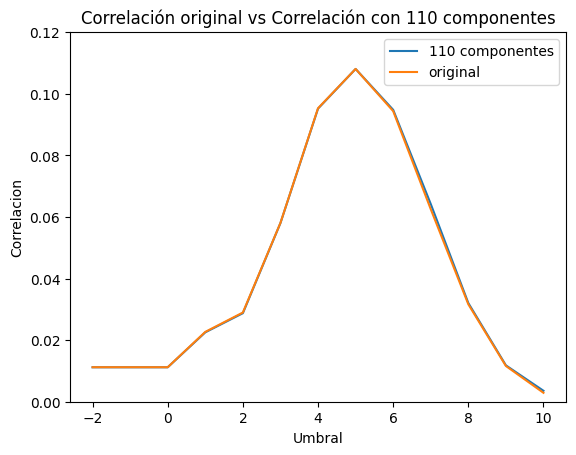

In [105]:
fig, ax = plt.subplots()
ax.plot(umbrales, mejor_correlacion, label="110 componentes")
ax.plot(umbrales, correlaciones_original, label="original")

plt.ylim(0, 0.12)
plt.legend()
plt.title("Correlación original vs Correlación con 110 componentes")
plt.xlabel("Umbral")
plt.ylabel("Correlacion")
plt.savefig(F"graficos/correlaciones_mejor.svg")

In [95]:
max = 0
for i in range(1, 319):
    if(data_all[i][2][0] > data_all[mejor][2][0]):
        max = i
print(max)

300


In [96]:
V_K = eigenvectors[ : ,:301]
VT_K = V_K.T
mayor_matriz = m_attrs@V_K

m_sim_aux = matriz_similaridad(mayor_matriz)
umbrales, mayor_correlacion = buscar_correlaciones(m_sim_aux, m_adyacencia, -2, 10)

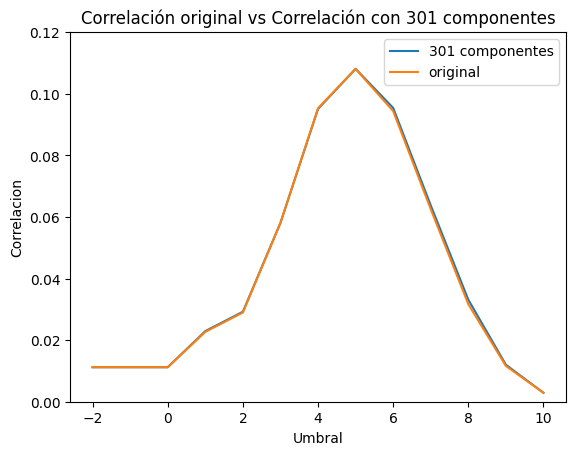

In [106]:
fig, ax = plt.subplots()
ax.plot(umbrales, mayor_correlacion, label="301 componentes")
ax.plot(umbrales, correlaciones_original, label="original")
plt.ylim(0, 0.12)
plt.legend()
plt.title("Correlación original vs Correlación con 301 componentes")
plt.xlabel("Umbral")
plt.ylabel("Correlacion")
plt.savefig(F"graficos/correlaciones_mayor.svg")

In [98]:
print(correlaciones_original[7]) ## la original
print(mejor_correlacion[7]) ## la que me dio mas cercana a la original
print(mayor_correlacion[7]) ## la que dio mayor correlacion

0.10804842659932785
0.10804781373715941
0.10808853056057895


## Conclusion: a pesar de que con k = 300 me dio mayor correlación, es casi despreciable la diferencia con k = 110 y nos ahorramos un monton de espacio asi que k = 110 es el mejor valor.